This note replicates the results in *Chen, Kaiji, Ayşe İmrohoroğlu, and Selahattin İmrohoroğlu (2006). The Japanese Saving Rate, American Economic Review, Vol. 96, Issue 5, 1850-1858.* 

## Model



A typical neo-classical growth model. For detail see paper.

## Data

In [1]:
file = 'data/JapanSavingRate/datafile.txt'
cols = ['year', 
        'gamma', # growth rate of TFP factor
        'pop',   # population growth rate
        'gov',   # government spending share
        'hh',    # hours input
        'ee',    # employment rate
        'delta', # depreciation rate
        'tau',   # capital income tax
        'jsrate' # actual Japanese net national saving rate
       ]
df = pd.read_csv(file, sep='\t', header=None, names=cols)

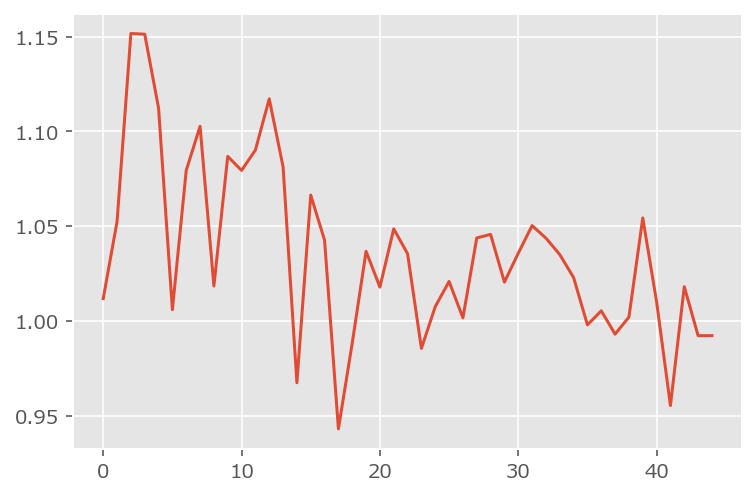

In [4]:
df.gamma.plot()

## Calibration and Computation

The computational strategy
- "start from actual Japanese capital-output ratio in 1956 and use a shooting algorithm to numerically compute the equilibrium transition path of the macroeconomic aggregates generated by the model as it converges to a final steady state"
- "To do this, first we obtain the equilibrium conditions for the economy and detrend them. The detrended steady-state saving rate, ... $\tilde{s}=\frac{(\gamma n-1) \tilde{k}}{\tilde{y}-\tilde{\delta} \tilde{k}}$ , and time-varying saving rates ... are given by, $s_{t}=\frac{Y_{t}-G_{t}-C_{t}-\delta_{t} K_{t}}{Y_{t}-\delta_{t} K_{t}}$"

4 parameters are time invariant: 
- capital share of output $\theta$ = 0.363 = sample average of GNP share of capital over 1956-2000
- subjective time discount factor $\beta$ = 0.96327 so that capital-output ratio is 2 at steady state
- total discretionary hours in a week $T$ = 105
- share of leisure in the utility function $\alpha$ = 1.45 to obtain an average labor input of 44 to match average aggregate hours in data 
- (Aggregate labor input is the product of average weekly hours worked and the employment rate, where the latter is taken as the ratio of total number of employed workers and working-age population.)

In our benchmark simulation, we use the actual time series data between 1956-2000 for the exogenous variables. For computation of steady state, we set exogenous variables equal to their sample average.
- TFP growth rate
- population growth rate
- depreciation rate
- share of government purchases in GNP
- capital income tax rate

implements the shooting algorithm used in Hayashi and Prescott (The structure of the shooting algorithm is nicely summarized in Judd (1998), pp. 355-357. )
- $c_t$, $h_t$, and $k_{t+1}$ for $t>=0$ are endogenous variables obtained by using the equilibrium conditions of the model.
- $k_0$ is a given initial condition
- $c_0$ is a guess, the subject of shooting
- $h_0$ is given by fvalue_ini2.m
- $k_{t+1}$ (for $t>=0$) is given by lines 142 and 143 in the main code
- $c_t$ and $h_t$ (for $t>=1$) are given by fvalue2.m

In [2]:
class JSRM:
    def __init__(self,
        # dataframe that save parameters in the real world
        df=df, 
        N = 2000, # length of period used for forward shooting algorithm ?
        
        # 4 invariant parameters
        theta   = 0.363,        # share of capital in production function
        beta    = 0.96327,      # utility discount factor     
        T       = 105,          # total discretionary hours in a week
        alpha   = 1.45,         # parameter for disutility of labor

        # model parameters at the steady state 
        # i.e. set exogenous variables equal to their sample average
        gamma_ss  = 1.0315,     # steady state TFP factor growth rate (corresponds to 2% TFP growth rate)
        pop_ss    = 1.011976,   # steady state value of growth rate of time endowment
        delta_ss  = 0.10,       # depreciation rate for physical capital at the steady state
        gov_ss    = 0.14,       # share of government spending in GNP at the steady state
        tau_ss    = 0.35,       # capital income tax rate at the steady state
        labor     = 31.82,      # exogenous labor input average over this time period
        
        # if replace some exogenous sequences to steady state value
        use_ss_then_real = None
):
        self.theta, self.beta, self.T, self.alpha = theta, beta, T, alpha
        self.gamma_ss, self.pop_ss, self.delta_ss = gamma_ss, pop_ss, delta_ss
        self.gov_ss, self.tau_ss, self.labor = gov_ss, tau_ss, labor
        self.N = N
        self.t_data = df.shape[0]
        
        # calucate final steady state values
        kh_ss = (
            (gamma_ss - beta + delta_ss * beta * (1 - tau_ss)) / (beta * (1 - tau_ss) * theta)
        ) ** (1 / (theta - 1))
        ch_ss = (1 - gov_ss) * kh_ss ** theta - kh_ss * (gamma_ss * pop_ss + delta_ss - 1)
        h_ss = T / (1 + alpha * ch_ss / ((1 - theta) * kh_ss ** theta))
        c_ss = ch_ss * h_ss
        k_ss = kh_ss * h_ss
        y_ss = k_ss ** theta * h_ss ** (1 - theta)
        save_ss = k_ss * (gamma_ss * pop_ss - 1) / (y_ss - delta_ss * k_ss)  # saving rate in ss
        ky_ss = k_ss / y_ss  # capital-output ratio in ss     
        
        self.kh_ss, self.ch_ss  = kh_ss, ch_ss
        self.h_ss, self.c_ss  = h_ss, c_ss
        self.k_ss, self.y_ss  = k_ss, y_ss
        self.save_ss, self.ky_ss  = save_ss, ky_ss
                
        # #When feeding in steady state numbers use these:
        # gamma   = np.array([gamma_ss]*n_years)
        # pop     = np.array([pop_ss]*n_years)
        # delta   = np.array([delta_ss]*n_years)
        # tau     = np.array([tau_ss]*n_years)
        # gov     = np.array([gov_ss]*n_years)
        # hh      = np.array([labor]*n_years)
        
        # Generating exogenous values for year beyond 2001
        n_years = len(df)
        self.year = np.r_[df.year.values, range(2001, N-n_years+2001)]
        self.gamma = np.r_[df.gamma.values, [gamma_ss]*(N-n_years)]
        self.pop = np.r_[df['pop'].values, [pop_ss]*(N-n_years)]
        self.delta = np.r_[df.delta.values, [delta_ss]*(N-n_years)]
        self.gov = np.r_[df.gov.values, [gov_ss]*(N-n_years)]    
        self.tau = np.r_[df.tau.values, [tau_ss]*(N-n_years)]
     
        # Replacing some exogenous sequences to steady state value
        if use_ss_then_real != None:
            if 'gamma' in use_ss_then_real:
                self.gamma = np.array([gamma_ss]*N)
            if 'pop' in use_ss_then_real:
                self.pop = np.array([pop_ss]*N)
            if 'delta' in use_ss_then_real:
                self.delta = np.array([delta_ss]*N)
            if 'gov' in use_ss_then_real:
                self.gov = np.array([gov_ss]*N)
            if 'tau' in use_ss_then_real:
                self.tau = np.array([tau_ss]*N)

In [3]:
def labor_choice(h, c, k, alpha, theta, T):
    """
    labor leisure choice at t period 
    given c_t, k_t, and parameters at steady state
    """
    diff = T-alpha*c/((1-theta)*(k/h)**theta) - h
    return diff

def comsuming_and_labor_choice(x, c, kprime, alpha, theta, T, 
                               beta, gamma, tau, delta,):
    """
    consuming choice and labor choice at t+1 period 
    given c_t, k_t+1, and parameters at steady state
    """
    cprime = x[0]
    hprime = x[1]
    
    # Euler equation
    diff_c = c/gamma*beta*(1+(1-tau)*(theta*(kprime/hprime)**(theta-1)-delta))-cprime
        
    # labor leisure choice
    diff_h = T-alpha*cprime/((1-theta)*(kprime/hprime)**theta)-hprime

    diff = [diff_c, diff_h]
    return diff

In [4]:
def shooting_model(m, 
                   # parameters related to shooting algorithm
                   epsilon = 1e-3,  # convegence criteria for shooting algorithm 
                   transp  = 99,    # number of periods until convergence to the steady-state
                   verbose = True
                  ):
    """
    Calculation of transition path, using forward shooting algorithm
    """
    
    theta, beta, T, alpha = m.theta, m.beta, m.T, m.alpha
    c_ss, k_ss = m.c_ss, m.k_ss
    gamma, tau, delta, pop, gov = m.gamma, m.tau, m.delta, m.pop, m.gov
    N = m.N

    c_L = c_ss*0.0;            # initial guess for lower bound for consumption
    c_H = c_ss*1.2;            # initial guess for upper bound for consumption

    # Setting initial capital stock
    ky_ini  = 1.37; # k/y ratio at 1956
    k0      = ky_ini**(1/(1-theta))*45.5;  # inital capital stock so that capital output ratio equal to data in 1956

    state   = 0                         # dummy variable for convergence
    i       = 0                         # shooting counter
    max_shooting = 200

    while (state != 3) & (i < max_shooting):
        state = 0

        # initialize sequences to be calculated to zero
        kk = np.zeros(N,) # k sequence
        cc = np.zeros(N,) # c sequence
        hh = np.zeros(N,)   # h sequence
        kkgg = np.zeros(N,) # k growth rate sequence
        ccgg = np.zeros(N,) # c growth rate sequence
        
        kk[0] = k0

        t = 0
        i = i + 1

        # update guess for consumption at initial period
        cc[0] = (c_L + c_H) / 2
        c0 = cc[0]

        # initial guess for h0
        h_ = 50.7
        # solve for h0, given k0 and c0
        h0 = sp.optimize.root(labor_choice, h_, args=(c0, k0, alpha, theta, T)).x
        hh[0] = h0

        # start shooting
        while t < N-1:
            # update k at t+1 period
            kk[t+1] = (
                (1 - delta[t]) * kk[t]
                + (1 - gov[t]) * (kk[t] ** theta * hh[t] ** (1 - theta))
                - cc[t]
            ) / (gamma[t] * pop[t])
            if kk[t+1] < 0:
                if verbose:
                    print(f'kk is negative at period {t+1}', end=' -> ')
                state = 1
                break
            elif not np.isreal(kk[t+1]):
                if verbose:
                    print(f'kk is imaginary at period {t+1}', end=' -> ')
                state = 1
                break

            # initial guess for c and h at period t+1
            x_ = [cc[t], hh[t]]
            
            # solve for optimal c and h for tomorrow
            res = sp.optimize.root(comsuming_and_labor_choice, x_, args=(
                    cc[t], kk[t+1], alpha, theta, T,
                    beta, gamma[t], tau[t+1], delta[t+1],),).x
    #         if not res.success:
    #             print('error in solve optimal c and h for tomorrow: fail to find root')

            cc[t+1] = res[0]
            hh[t+1] = res[1]

            cgrow = cc[t+1] / cc[t]
            kgrow = kk[t+1] / kk[t]
            ccgg[t] = cgrow
            kkgg[t] = kgrow
            
            t = t + 1

            if (cgrow <=1) & (t>transp):
                state=2
                if verbose:
                    print(f'consumption does not grow at period {t}', end=' -> ')
                break
            elif (kgrow <=1) & (t>transp):
                state=1
                if verbose:
                    print(f'capital does not grow at period {t}', end=' -> ')
                break

        # check convergence and update c_L (or c_H)
        # caution: it seems to fail to converge if set a smaller e like 1e-4 
        if (abs(cc[t]-c_ss) < epsilon) & (abs(kk[t]-k_ss) < epsilon*10):
            state=3
            print(f'Converged to final ss at period {t}')
            break
        elif state==2:
            c_L = cc[0]
            if verbose:
                print('c_L increased')
        elif state==1:
            c_H = cc[0]
            if verbose:
                print('c_H lowered');
        else:
            if verbose:
                print(f'number of iterations exceeded without convergence N and t are {N}, {t}')
            break

    if i >= max_shooting:
        print('Converge Failed')
    
    # calculating values in the model
    kk = kk[:t]
    cc = cc[:t]
    hh = hh[:t]
    delta = delta[:t]
    gov = gov[:t]
    tau = tau[:t]

    yy      = kk**theta*hh**(1-theta)               # GNP
    rr      = (yy*theta/kk)-delta                   # rate of return for capital
    rr      = rr*(1-tau)                            # after tax rate of return
    savrate = (yy*(1-gov)-cc-kk*delta)/(yy-kk*delta) # saving rate
    ky      = kk/yy  
    
    # save results to a dataframe
    res = pd.DataFrame({'year':m.year[:t],'k':kk, 'c':cc, 'hh':hh, 'y':yy,
                            'ky':ky, 'r':rr, 'saverate':savrate})

    return t, res

In [5]:
m = JSRM()

In [6]:
t, res = shooting_model(m)

consumption does not grow at period 100 -> c_L increased
kk is negative at period 8 -> c_H lowered
consumption does not grow at period 100 -> c_L increased
consumption does not grow at period 100 -> c_L increased
kk is negative at period 13 -> c_H lowered
consumption does not grow at period 100 -> c_L increased
kk is negative at period 22 -> c_H lowered
consumption does not grow at period 100 -> c_L increased
consumption does not grow at period 100 -> c_L increased
kk is negative at period 34 -> c_H lowered
consumption does not grow at period 100 -> c_L increased
consumption does not grow at period 100 -> c_L increased
consumption does not grow at period 100 -> c_L increased
kk is negative at period 48 -> c_H lowered
consumption does not grow at period 100 -> c_L increased
consumption does not grow at period 100 -> c_L increased
consumption does not grow at period 100 -> c_L increased
kk is negative at period 59 -> c_H lowered
consumption does not grow at period 100 -> c_L increased
co

<ipython-input-3-c036b85ede5c>:19: RuntimeWarning: invalid value encountered in double_scalars
  diff_c = c/gamma*beta*(1+(1-tau)*(theta*(kprime/hprime)**(theta-1)-delta))-cprime
<ipython-input-3-c036b85ede5c>:22: RuntimeWarning: invalid value encountered in double_scalars
  diff_h = T-alpha*cprime/((1-theta)*(kprime/hprime)**theta)-hprime


 -> c_L increased
kk is negative at period 90 -> c_H lowered
consumption does not grow at period 100 -> c_L increased
kk is negative at period 95 -> c_H lowered
consumption does not grow at period 100 -> c_L increased
kk is negative at period 99 -> c_H lowered
capital does not grow at period 100 -> c_H lowered
capital does not grow at period 100 -> c_H lowered
consumption does not grow at period 100 -> c_L increased
consumption does not grow at period 100 -> c_L increased
consumption does not grow at period 100 -> c_L increased
consumption does not grow at period 100 -> c_L increased
capital does not grow at period 100 -> c_H lowered
consumption does not grow at period 100 -> c_L increased
consumption does not grow at period 100 -> c_L increased
capital does not grow at period 100 -> c_H lowered
consumption does not grow at period 100 -> c_L increased
capital does not grow at period 100 -> c_H lowered
consumption does not grow at period 100 -> Converged to final ss at period 100


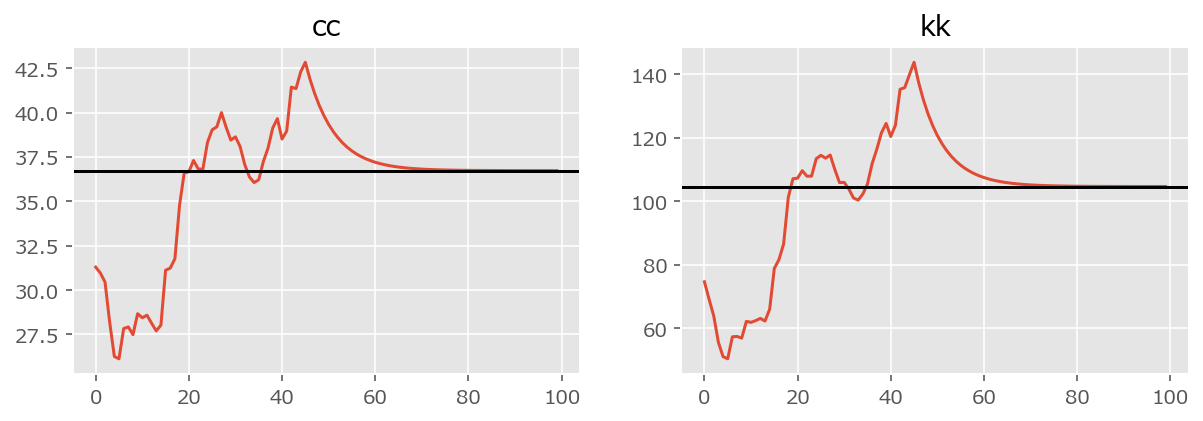

In [7]:
def draw_converg(res, m):
    fig, ax = plt.subplots(1, 2, figsize=(10,3))
    ax[0].plot(res.c,); ax[0].set_title('cc'); ax[0].axhline(m.c_ss, c='black')
    ax[1].plot(res.k,); ax[1].set_title('kk'); ax[1].axhline(m.k_ss, c='black')

draw_converg(res, m)

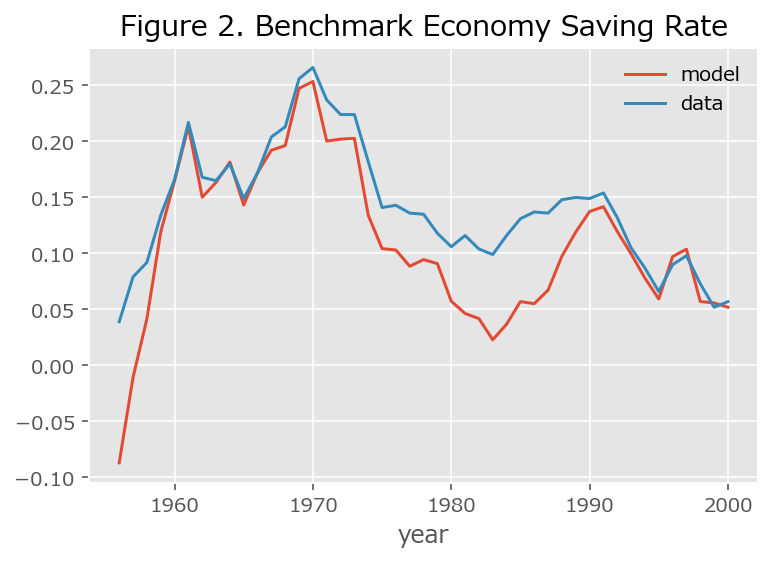

In [8]:
def draw_savrate(res, m, title='Figure 2. Benchmark Economy Saving Rate'):
    fig,ax=plt.subplots()
    res[:m.t_data].plot('year','saverate', label='model', ax=ax)
    df.plot('year', 'jsrate', label='data', ax=ax)
    ax.set_title(title)
draw_savrate(res, m)

The process seems to be very similar if we set the steady state values to most recent values in dataset rather than the average over the period. The initial consuming level will be very close. Accually, in infinite horizon optimal control problems, the initial state corresponding to any terminal state is relatively insensitive to the terminal state. (for detail see Judd 1998, sec 10.7).

This also implies, inversely, that the terminal value is very senstive to intial value when $T$ is large. In the early (real) periods, the consuming and saving in the economy converges to different steady state under varying coefficients, i.e. the agents in the economy foresee no changes but believe recent coefficients will be constant thereafter. Thus the process of converging to a final steady state in the far future is very important to pin down the early path of the consuming and saving level.  

In [9]:
re = df.iloc[-1]
m = JSRM(df, pop_ss=re['pop'], gamma_ss=re.gamma, gov_ss=re.gov, 
         delta_ss=re.delta, tau_ss=re.tau, labor=re.hh)
t, res = shooting_model(m)

consumption does not grow at period 100 -> c_L increased
kk is negative at period 3 -> c_H lowered
kk is negative at period 5 -> c_H lowered
kk is negative at period 7 -> c_H lowered
kk is negative at period 13 -> c_H lowered
consumption does not grow at period 100 -> c_L increased
kk is negative at period 35 -> c_H lowered
consumption does not grow at period 100 -> c_L increased
consumption does not grow at period 100 -> c_L increased
consumption does not grow at period 100 -> c_L increased
consumption does not grow at period 100 -> c_L increased
consumption does not grow at period 100 -> c_L increased
consumption does not grow at period 100 -> c_L increased
consumption does not grow at period 100 -> c_L increased
kk is negative at period 41 -> c_H lowered
consumption does not grow at period 100 -> c_L increased
kk is negative at period 46 -> c_H lowered
kk is negative at period 56 -> c_H lowered
consumption does not grow at period 100 -> c_L increased
consumption does not grow at per

<ipython-input-3-c036b85ede5c>:19: RuntimeWarning: invalid value encountered in double_scalars
  diff_c = c/gamma*beta*(1+(1-tau)*(theta*(kprime/hprime)**(theta-1)-delta))-cprime
<ipython-input-3-c036b85ede5c>:22: RuntimeWarning: invalid value encountered in double_scalars
  diff_h = T-alpha*cprime/((1-theta)*(kprime/hprime)**theta)-hprime


 -> c_L increased
kk is negative at period 95 -> c_H lowered
kk is negative at period 100 -> c_H lowered
capital does not grow at period 100 -> c_H lowered
consumption does not grow at period 100 -> c_L increased
capital does not grow at period 100 -> c_H lowered
consumption does not grow at period 100 -> c_L increased
consumption does not grow at period 100 -> c_L increased
consumption does not grow at period 100 -> c_L increased
consumption does not grow at period 114 -> c_L increased
capital does not grow at period 100 -> c_H lowered
capital does not grow at period 100 -> c_H lowered
capital does not grow at period 100 -> c_H lowered
capital does not grow at period 102 -> c_H lowered
capital does not grow at period 105 -> c_H lowered
capital does not grow at period 109 -> c_H lowered
capital does not grow at period 120 -> c_H lowered
consumption does not grow at period 117 -> c_L increased
consumption does not grow at period 120 -> c_L increased
consumption does not grow at period 1

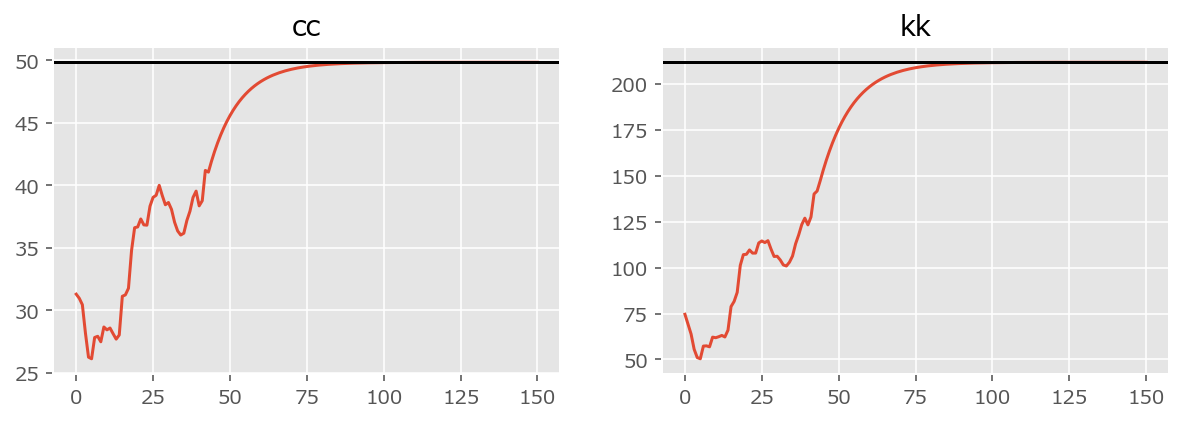

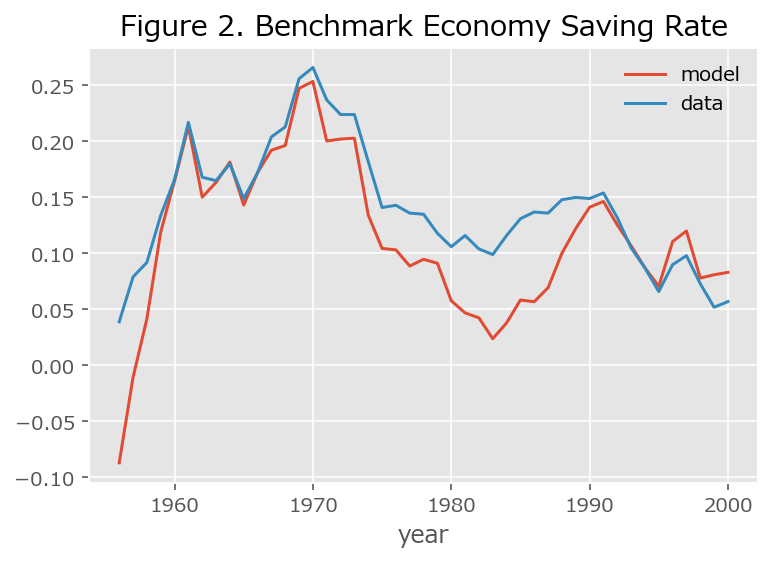

In [10]:
draw_converg(res, m)
draw_savrate(res, m)

In [11]:
def evolve_given_c0(m, c0=31.29):
    
    t = m.t_data
    theta, beta, T, alpha = m.theta, m.beta, m.T, m.alpha
    c_ss, k_ss = m.c_ss, m.k_ss
    gamma, tau, delta, pop, gov = m.gamma, m.tau, m.delta, m.pop, m.gov
    
    kk = np.zeros(t,) # k sequence
    cc = np.zeros(t,) # c sequence
    hh = np.zeros(t,)   # h sequence
    delta = delta[:t]
    gov = gov[:t]
    tau = tau[:t]
    
    cc[0] = c0
    
    # Setting initial capital stock
    ky_ini  = 1.37; # k/y ratio at 1956
    k0      = ky_ini**(1/(1-theta))*45.5;  # inital capital stock so that capital output ratio equal to data in 1956
    kk[0] = k0
    
    # initial guess for h0
    h_ = 50.7
    # solve for h0, given k0 and c0
    h0 = sp.optimize.root(labor_choice, h_, args=(c0, k0, alpha, theta, T)).x
    hh[0] = h0
    
    for i in range(t-1):
        kk[i+1] = (
            (1 - delta[i]) * kk[i]
            + (1 - gov[i]) * (kk[i] ** theta * hh[i] ** (1 - theta))
            - cc[i]
        ) / (gamma[i] * pop[i])
        
        x_ = [cc[i], hh[i]]
        # solve for optimal c and h for tomorrow
        res = sp.optimize.root(comsuming_and_labor_choice, x_, args=(
                cc[i], kk[i+1], alpha, theta, T,
                beta, gamma[i], tau[i+1], delta[i+1],),).x
        cc[i+1] = res[0]
        hh[i+1] = res[1]
        

    yy      = kk**theta*hh**(1-theta)               # GNP
    rr      = (yy*theta/kk)-delta                   # rate of return for capital
    rr      = rr*(1-tau)                            # after tax rate of return
    savrate = (yy*(1-gov)-cc-kk*delta)/(yy-kk*delta) # saving rate
    ky      = kk/yy  
    
    # save results to a dataframe
    res = pd.DataFrame({'year':m.year[:t],'k':kk, 'c':cc, 'hh':hh, 'y':yy,
                            'ky':ky, 'r':rr, 'saverate':savrate})        
    return res

<ipython-input-3-c036b85ede5c>:19: RuntimeWarning: invalid value encountered in double_scalars
  diff_c = c/gamma*beta*(1+(1-tau)*(theta*(kprime/hprime)**(theta-1)-delta))-cprime
<ipython-input-3-c036b85ede5c>:22: RuntimeWarning: invalid value encountered in double_scalars
  diff_h = T-alpha*cprime/((1-theta)*(kprime/hprime)**theta)-hprime
<ipython-input-11-62c67354932b>:31: RuntimeWarning: invalid value encountered in double_scalars
  + (1 - gov[i]) * (kk[i] ** theta * hh[i] ** (1 - theta))
<ipython-input-11-62c67354932b>:44: RuntimeWarning: invalid value encountered in power
  yy      = kk**theta*hh**(1-theta)               # GNP


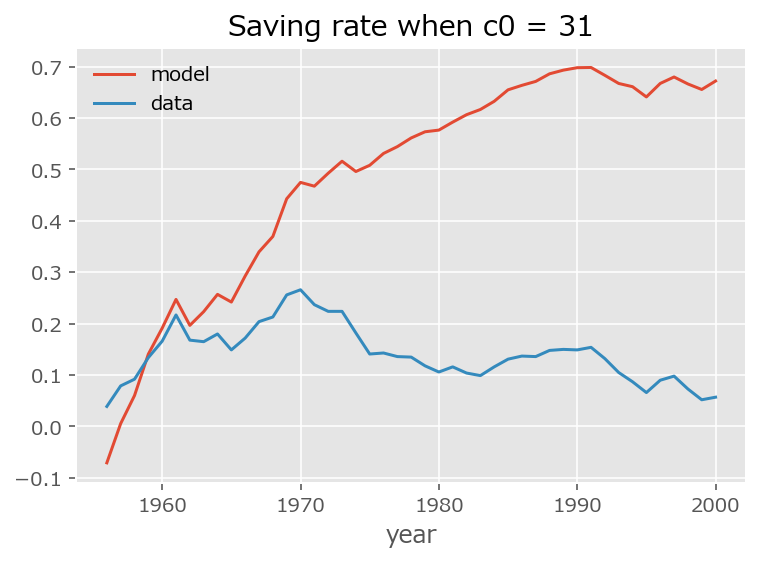

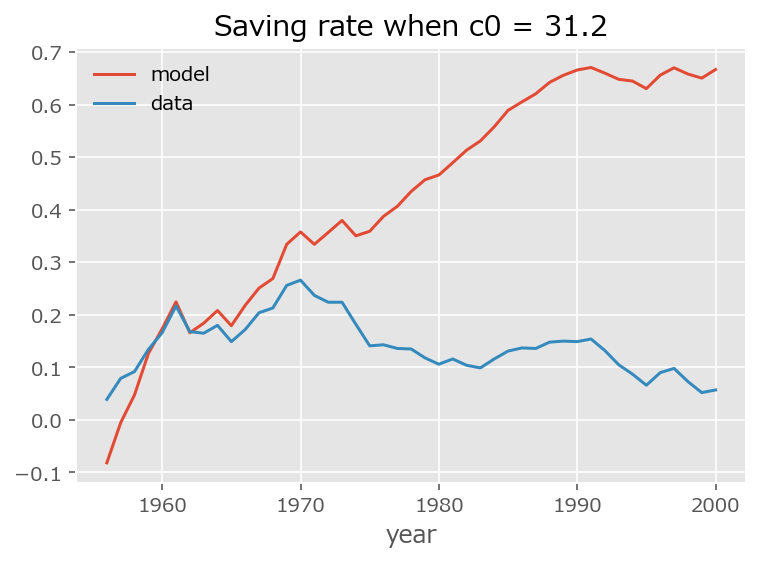

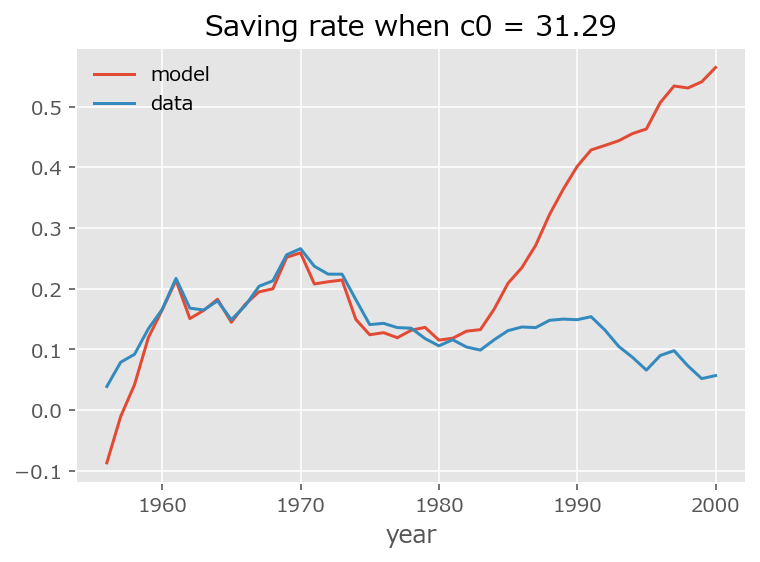

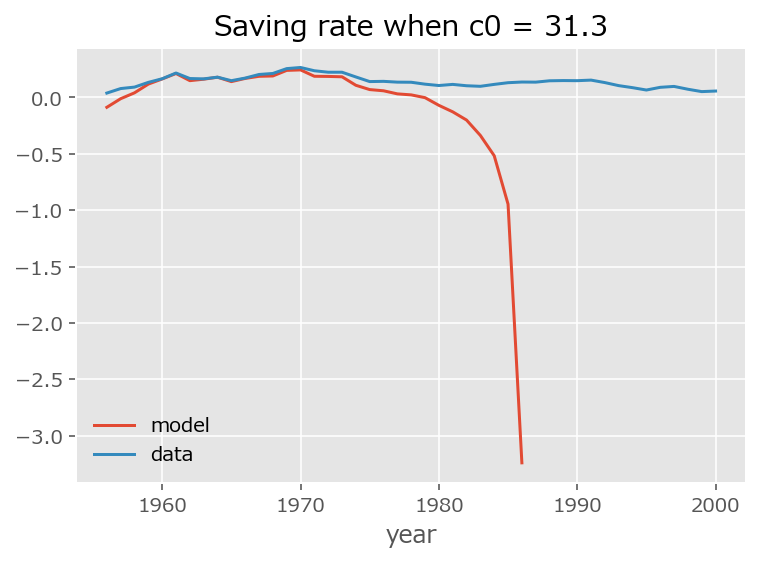

In [12]:
for c0 in [31, 31.2, 31.29, 31.30]:
    m = JSRM()
    res = evolve_given_c0(m, c0=c0)
    draw_savrate(res,m, title=f'Saving rate when c0 = {c0}')

<ipython-input-3-c036b85ede5c>:19: RuntimeWarning: invalid value encountered in double_scalars
  diff_c = c/gamma*beta*(1+(1-tau)*(theta*(kprime/hprime)**(theta-1)-delta))-cprime
<ipython-input-3-c036b85ede5c>:22: RuntimeWarning: invalid value encountered in double_scalars
  diff_h = T-alpha*cprime/((1-theta)*(kprime/hprime)**theta)-hprime


Converged to final ss at period 100


<ipython-input-3-c036b85ede5c>:19: RuntimeWarning: invalid value encountered in double_scalars
  diff_c = c/gamma*beta*(1+(1-tau)*(theta*(kprime/hprime)**(theta-1)-delta))-cprime
<ipython-input-3-c036b85ede5c>:22: RuntimeWarning: invalid value encountered in double_scalars
  diff_h = T-alpha*cprime/((1-theta)*(kprime/hprime)**theta)-hprime


Converged to final ss at period 100


<ipython-input-3-c036b85ede5c>:19: RuntimeWarning: invalid value encountered in double_scalars
  diff_c = c/gamma*beta*(1+(1-tau)*(theta*(kprime/hprime)**(theta-1)-delta))-cprime
<ipython-input-3-c036b85ede5c>:22: RuntimeWarning: invalid value encountered in double_scalars
  diff_h = T-alpha*cprime/((1-theta)*(kprime/hprime)**theta)-hprime
<ipython-input-3-c036b85ede5c>:19: RuntimeWarning: invalid value encountered in double_scalars
  diff_c = c/gamma*beta*(1+(1-tau)*(theta*(kprime/hprime)**(theta-1)-delta))-cprime
<ipython-input-3-c036b85ede5c>:22: RuntimeWarning: invalid value encountered in double_scalars
  diff_h = T-alpha*cprime/((1-theta)*(kprime/hprime)**theta)-hprime


Converged to final ss at period 100
Converged to final ss at period 100


<ipython-input-3-c036b85ede5c>:19: RuntimeWarning: invalid value encountered in double_scalars
  diff_c = c/gamma*beta*(1+(1-tau)*(theta*(kprime/hprime)**(theta-1)-delta))-cprime
<ipython-input-3-c036b85ede5c>:22: RuntimeWarning: invalid value encountered in double_scalars
  diff_h = T-alpha*cprime/((1-theta)*(kprime/hprime)**theta)-hprime


Converged to final ss at period 100


<ipython-input-3-c036b85ede5c>:19: RuntimeWarning: invalid value encountered in double_scalars
  diff_c = c/gamma*beta*(1+(1-tau)*(theta*(kprime/hprime)**(theta-1)-delta))-cprime
<ipython-input-3-c036b85ede5c>:22: RuntimeWarning: invalid value encountered in double_scalars
  diff_h = T-alpha*cprime/((1-theta)*(kprime/hprime)**theta)-hprime


Converged to final ss at period 100


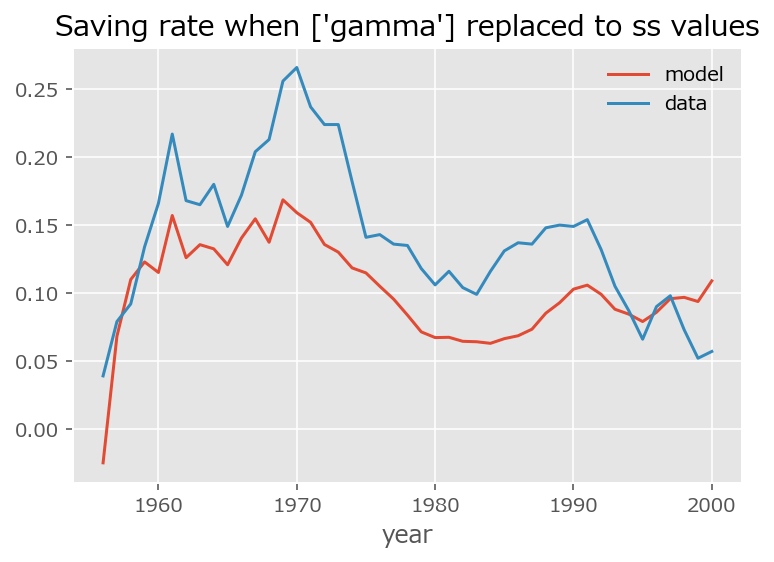

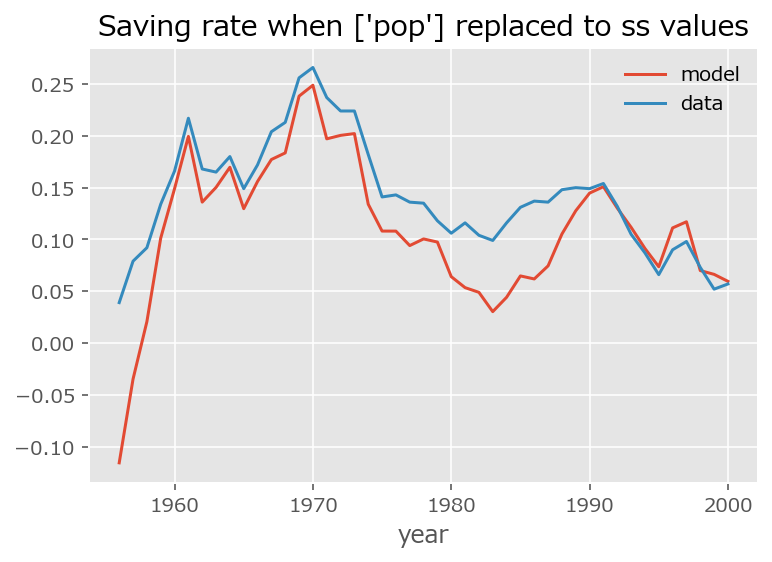

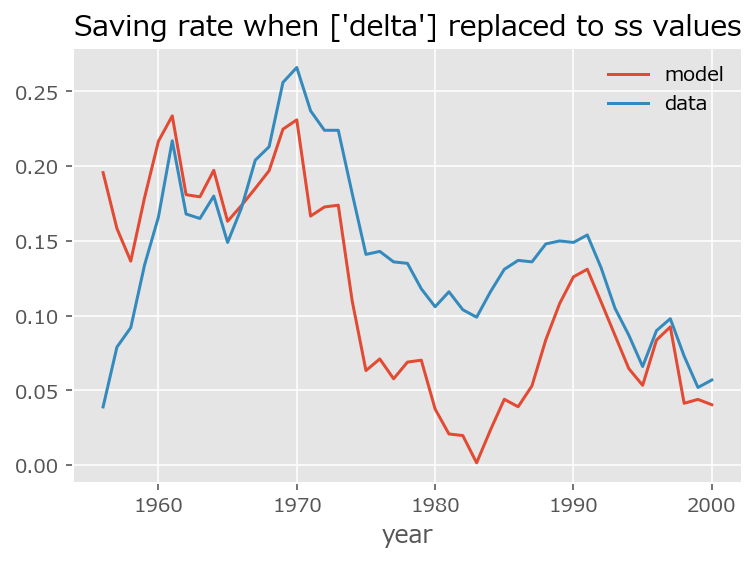

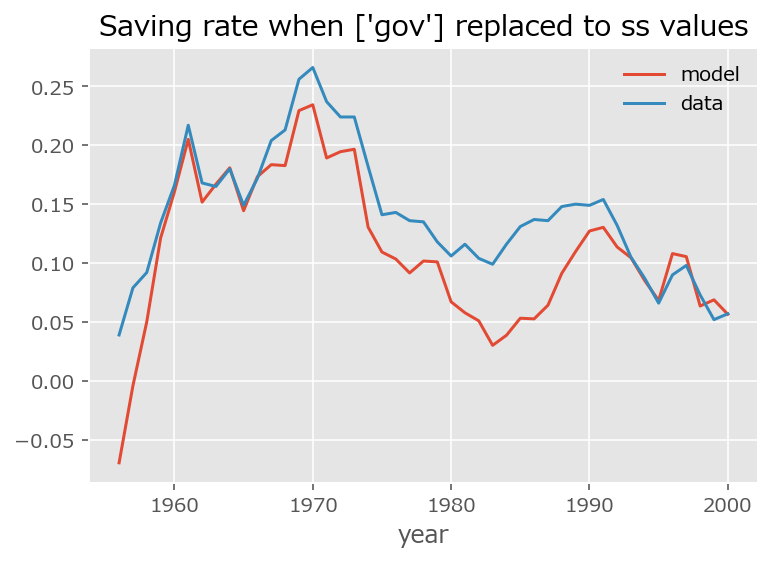

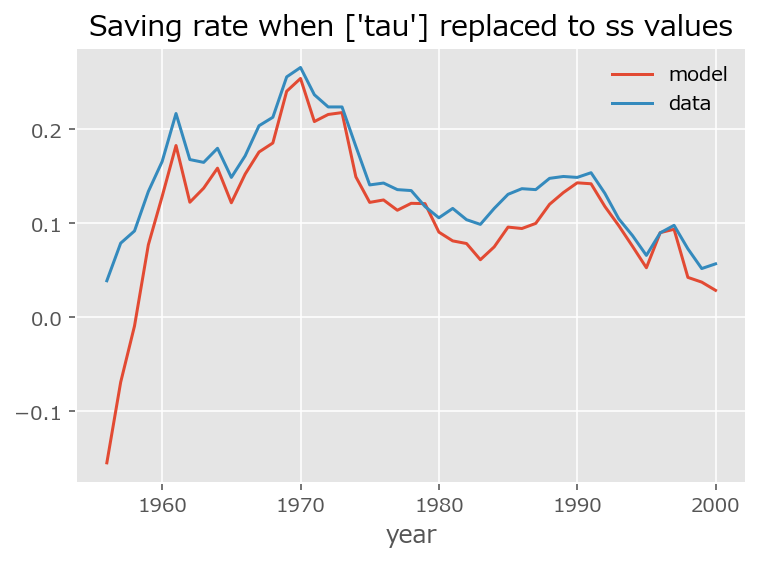

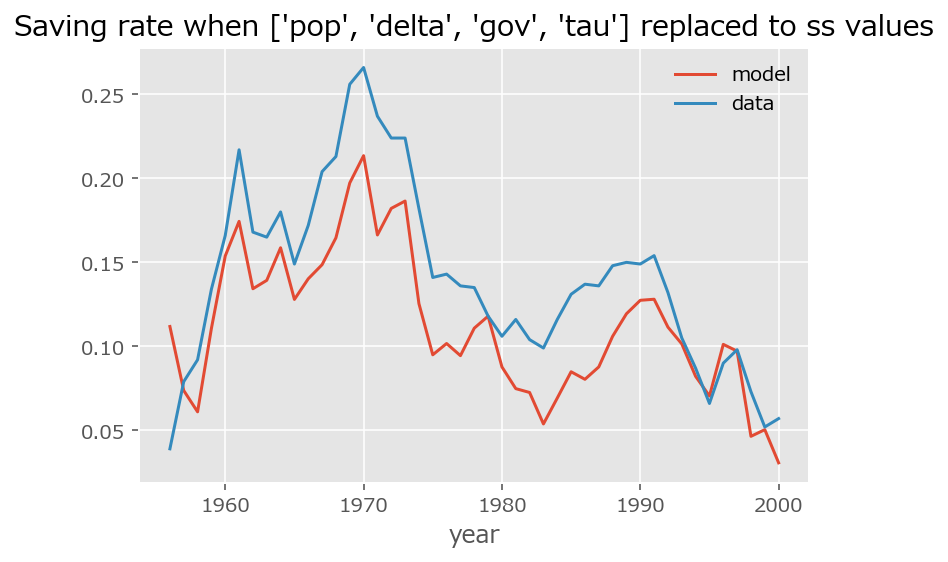

In [13]:
for i in [['gamma'], ['pop'], ['delta'], ['gov'], ['tau'],
          ['pop','delta','gov','tau'],
         ]:
    m = JSRM(use_ss_then_real=i)
    t, res = shooting_model(m, verbose=False)
    draw_savrate(res,m, title=f'Saving rate when {i} replaced to ss values')